----
### 测试滤波函数

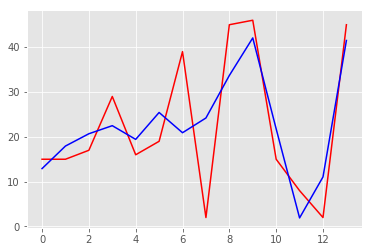

In [4]:
#测试sg信号滤波功能函数
from scipy.signal import savgol_filter
x = [15,15,17,29,16,19,39,2,45,46,15,8,2,45]
y = savgol_filter(x, 5,2)
plt.plot(x,c='r')
plt.plot(y,c='b')

-----------------------------


# 基于S-G滤波的SIF时间序列数据重建
1. 把所有nc文件中黄淮海区域的数据提取出来，分别存储为独立的tiff文件。
2. 将tiff文件循环读入形成文件列表，根据文件地址索引构建时间序列研究区sif数据的三维数组。
3. 逐像元构建时间序列数据进行滤波平滑处理，滤波后的数据存储为新的数组，把数组写入投影及仿射变换信息，另存为tiff。

In [1]:
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
from osgeo import osr,ogr,gdal
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
from glob import glob 
import os 
import math 
import numpy as np
from scipy import interpolate
from scipy.signal import savgol_filter
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from datetime import datetime
import time

dates = np.arange('2019-03-01', '2019-06-01', dtype='datetime64[1D]').astype(datetime)
plot_range = np.arange('2019-02-28', '2019-06-03', dtype='datetime64[1D]').astype(datetime)

def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)

    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data)-1 not in idx_x:
        idx_x.append(len(data)-1)
        idx_y.append(idx_y[-1])

    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data)):
        if math.isnan(data[i]):
            data[i] = lin(i)
    return data


tiff_path = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/dcSIF/MEAN/zuotu/'#将0.1°分辨率的tiff文件读入到array数组中
filelist = glob(tiff_path+'*.tif')
filelen = len(filelist)
tif=gdal.Open(filelist[0])
width = tif.RasterXSize
height = tif.RasterYSize
array = np.zeros((filelen,height,width),dtype=np.float64)
i = 0
for file in filelist:
    #时间序列的SIF数组
    dataset = gdal.Open(file)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    data = dataset.ReadAsArray(0,0,width,height)
    array[i,:,:]=data
    i+=1

for h in range(0,height,10):
    for w in range(0,width,10):
        try:
            x = array[:,h,w]/10000.#每个像素的时间序列
            x_min = np.min(x)
            length = len(dates)
            index = np.where(x == -0.0099)
            dates_nan = dates[index]
            nan_length = len(dates_nan)# 无效时间区间长度
            x[np.where(x == -0.0099)] = np.nan


            plt.figure(figsize = (20,10))
            ax=plt.subplot(311)
            ax.scatter(dates,x,c='b')
            ax_nan=np.zeros(nan_length)+x_min
            ax.scatter(dates_nan,ax_nan,c='r',marker = 'x')
            plt.ylabel('dcSIF (W/m$^2$/sr/$\mu$m)')
            monthsLoc = mpl.dates.MonthLocator()
            monthsFmt = mpl.dates.DateFormatter('%Y-%m-%d') #%Y %b 为年月
            ax.xaxis.set_major_locator(monthsLoc)
            ax.xaxis.set_major_formatter(monthsFmt)
            plt.xlim(plot_range[0],plot_range[-1])
            plt.tick_params(labelsize=13)
            


            ax2 = plt.subplot(312)
            xx = fillna_with_interpolation(x)#插值NAN值
            #ax2.plot(dates,xx,c='b',marker = '*',markerfacecolor='r',markeredgecolor='r')
            ax2.plot(dates,xx,c='b',marker = 'o')
            plt.ylabel('插值后的SIF时间序列')
            ax2.xaxis.set_major_locator(monthsLoc)
            ax2.xaxis.set_major_formatter(monthsFmt)
            plt.xlim(plot_range[0],plot_range[-1])
            plt.tick_params(labelsize=13)


            ax3 = plt.subplot(313)
            yy = savgol_filter(xx,7,2)
            ax3.plot(dates,xx,'b',linestyle='--')
            ax3.plot(dates,yy,'r')
            lat = 43.-h*0.1
            lon = 110+w*0.1
            plt.ylabel(str(lat)+' '+str(lon)+' 滤波后的时间序列')
            ax3.xaxis.set_major_locator(monthsLoc)
            ax3.xaxis.set_major_formatter(monthsFmt)
            plt.xlim(plot_range[0],plot_range[-1])
            plt.tick_params(labelsize=13)
            #continue
            plt.savefig(tiff_path+'/png/'+'h_'+str(h)+'_w_'+str(w)+'.png',dpi=300)
            plt.close()
            
        except Exception as e:
            print ('H_'+str(h)+'_W_'+str(w)+"exception")
            continue
           
    
        break
    break

ModuleNotFoundError: No module named 'netCDF4'

## 将所有区域进行滤波

In [79]:

#新建数组存储每一个像元位置插值滤波后的结果
shape =np.shape(array)
sg_result = np.empty(shape,dtype = float)#新建一个array相同大小的数组用于存储滤波后的结果数据
for h in range(0,height):
    for w in range(0,width):
        try: 
            x = array[:,h,w]#每个像素的时间序列
            length = len(x)#时间区间长度
            index = np.where(x == -99)
            x[np.where(x == -99)] = np.nan
            xx = fillna_with_interpolation(x)#插值NAN值
            yy = savgol_filter(xx,7,2)
            sg_result[:,h,w]=yy
        except:
            sg_result[:,h,w]=np.nan
print('sg滤波完成')
   

sg滤波完成


## 批处理完成滤波后的tif存储

In [81]:
from glob import glob
from osgeo import gdal
import os
from glob import glob
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    #新tif文件的全路径，输出tiff左上角起始经纬度，宽度，高度，数组
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float64)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
outpath = 'D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/'
tiff_path = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/dcSIF/MEAN/'
filelist = glob(tiff_path+'*.tif')
filelen = len(filelist)
tif=gdal.Open(filelist[0])
width = tif.RasterXSize
height = tif.RasterYSize
array = np.zeros((filelen,height,width),dtype=np.float64)
i = 0
rasterOrigin = (110,43)#输出tiff左上角经纬度
pixelWidth = 0.1
pixelHeight = -0.1
outfilelist = []
for file in filelist:    
    newRasterfn = outpath+str(os.path.basename(file)[:-3])+'sgfilter.tif'
#     reversed_arr = sif_arr[::-1]
#     array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr)
#     print(newRasterfn+'   还剩下_'+str(filelen)+'_个文件。')
    outfilelist.append(newRasterfn) 

for i in range(array.shape[0]):
    #把sg数组分日期存储为tiff
    daily_sg = sg_result[i,:,:]
    #reversed_arr = daily_sg[::-1]#右面应为每日sg结果数据
    array2raster(outfilelist[i],rasterOrigin,pixelWidth,pixelHeight,daily_sg)
    print(outfilelist[i]+'计算完成tif')


D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-01_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-02_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-03_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-04_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-05_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-06_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-07_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-08_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-09_ungridded_dcSIF_mean.sgfilter.tif计算完成tif
D:/wsy/Data/SIF/TROPO/sgfilter/0.1/dcSIF/TROPO_SIF_2018-09-10_ungridded_d

---
## 显示滤波后的sif

In [2]:
%matplotlib inline
#from L2_tools import *
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
from glob import glob
from osgeo import gdal
from osgeo import ogr,osr
import os
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

c:\python37\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
#显示列表前n个最大值及索引
def list_index(array,n):
    import heapq
    re1 = heapq.nlargest(3,array) #求最大的三个元素，并排序
    re2 = map(array.index, heapq.nlargest(3, array)) #求最大的三个索引    nsmallest与nlargest相反，求最小
    return re1,list(re2)#因为re2由map()生成的不是list，直接print不出来，添加list()就行了


In [4]:

def plot_sif(arr,shape_dir,outpath):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from mpl_toolkits.basemap import Basemap
    TVDI = arr
    lon_start = 110.
    lon_stop = 123.
    lat_start = 30.
    lat_stop = 43.
    lon_step = 0.1
    lat_step = 0.1

    xx = np.arange(lon_start, lon_stop, lon_step) 
    yy = np.arange(lat_start, lat_stop, lat_step)    
    lons, lats = np.meshgrid(xx,yy)

    plt.figure(figsize=(6,5))
    m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=43,llcrnrlon=110, urcrnrlon=123, suppress_ticks=True)
    parallels = np.arange(30, 43, 2)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.25)
    meridians = np.arange(110., 123, 2)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.25)

    m.readshapefile(shape_dir, 'limites', linewidth=0.5)
    #TVDI_reverse = np.flipud(TVDI)
    arrmax = np.nanmax(TVDI)
    cm = m.pcolormesh(lons,lats,TVDI,vmin = -0.2, vmax = 2.0, latlon=True, cmap='YlGnBu')#修改vmax为最大值范围，可改为arrmax
    cbar = m.colorbar(cm, location='right', pad="5%")
    cbar.set_label('SIF')
    plt.title('dcSIF on NCP', fontsize=14)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

In [2]:
def sif_plot(latMin,latMax,lonMin,lonMax,sif_arr,outpath):
    plt.style.use('ggplot')
    plt.figure(figsize = (6,6))
    plt.rcParams['font.sans-serif']=['SimHei']
    # plt.subplot(211)
    arrmax = np.nanmax(sif_arr)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:0.8,lonMin:lonMax:0.1]
    plt.pcolor(lon_arr,lat_arr,sif_arr,cmap='YlGnBu',vmin=0,vmax=arrmax)
    plt.title('黄淮海地区平滑滤波后dcSIF区域均值')
    plt.rcParams['axes.unicode_minus'] = False
    plt.colorbar()
    plt.savefig(outpath,dpi=300)
    
def sif_array(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.sif[index] > 0)#排除小于0的数据
            if tropomi_data.sif[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.sif[index].mean()   #*10000
                sif_arr[x,y] = sif_mean
    return(sif_arr)

path = r'F:\RS_DATA\SIF\TROPO\tiff\sgfilter\0.1\dcSIF\\'
outdir = r'F:\RS_DATA\SIF\TROPO\tiff\sgfilter\0.1\dcSIF\pic\vmax为-0.2-2.0\\'
#outdir = r'D:\wsy\Data\SIF\TROPO\tiff\sgfilter\0.1\dcSIF\pic\\'
shape_dir = r'D:\wsy\Data\基础支持数据\矢量边界\\5province'
filelist = glob(path+'*.tif')
filelen= len(filelist)
path_tropomi = filelist[0]
latMin = 30.
latMax = 43.
lonMin = 110.
lonMax = 123.
for file in filelist:
    name = os.path.basename(file)[:-4]
    #print(name)
    gdal.AllRegister()
    ds = gdal.Open(file)
    rows = ds.RasterYSize
    cols = ds.RasterXSize
    tf = ds.GetGeoTransform()
    proj = ds.GetProjectionRef()
    xOrigin = tf[0]
    yOrigin = tf[3]
    pixelWidth = tf[1]
    pixelHeight = tf[5]
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()
    sif_arr = data[::-1]/10000.
    #print(np.nanmax(sif_arr))
    outpath = outdir+name+'.png'
    #sif_plot(latMin,latMax,lonMin,lonMax,sif_arr,outpath)
    plot_sif(sif_arr,shape_dir,outpath)
    #break

NameError: name 'glob' is not defined

-------------

78 82 34 38
4 4


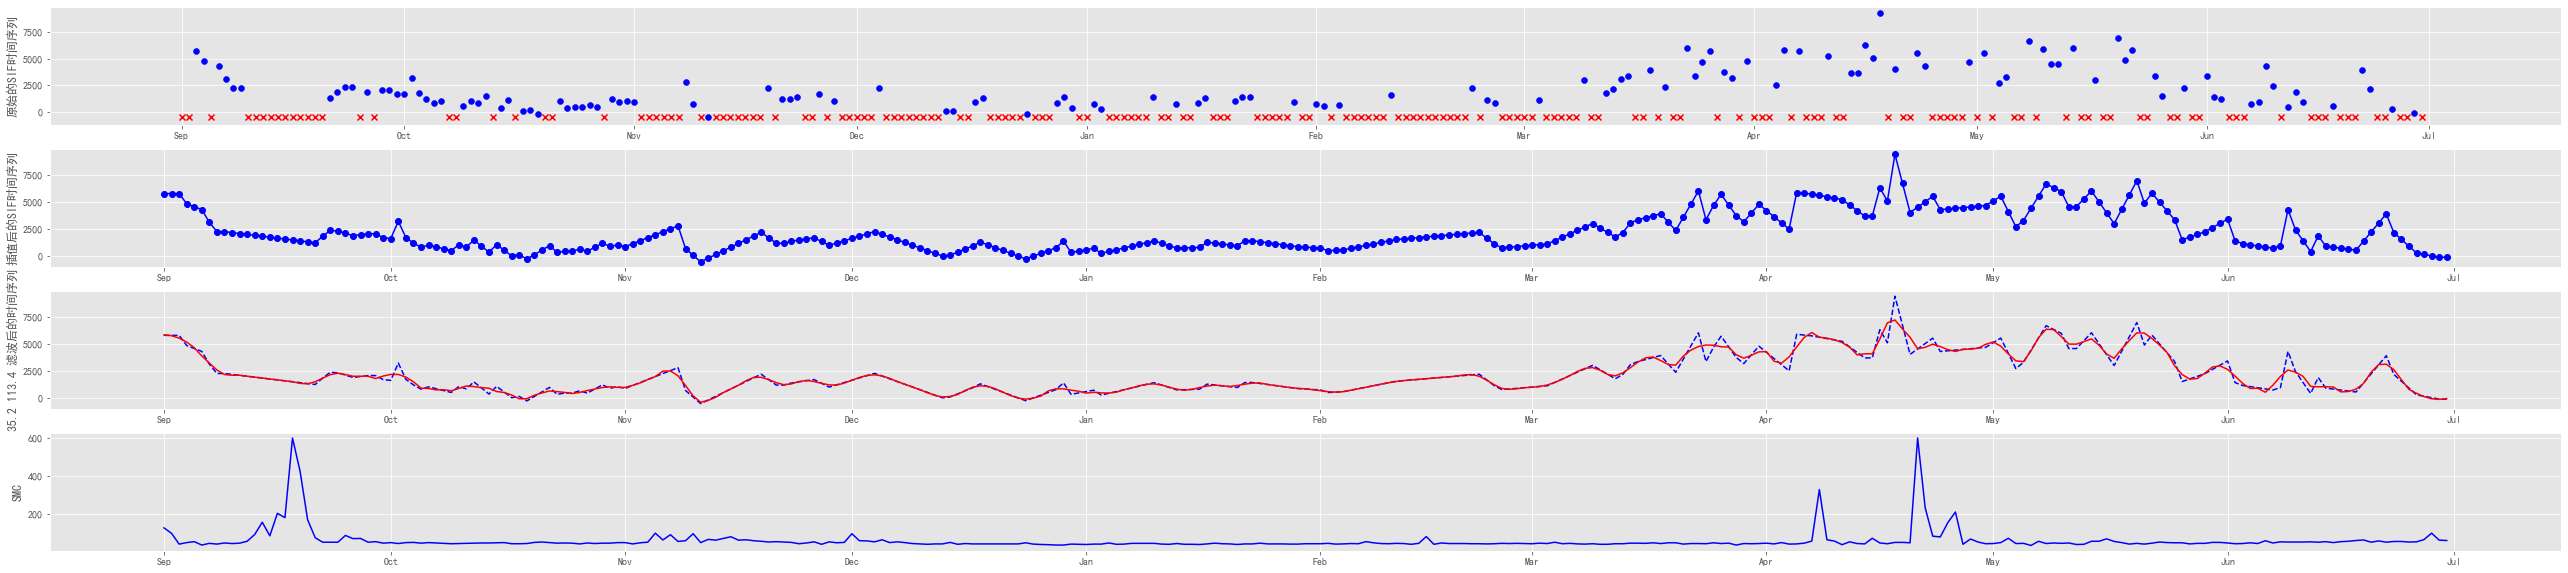

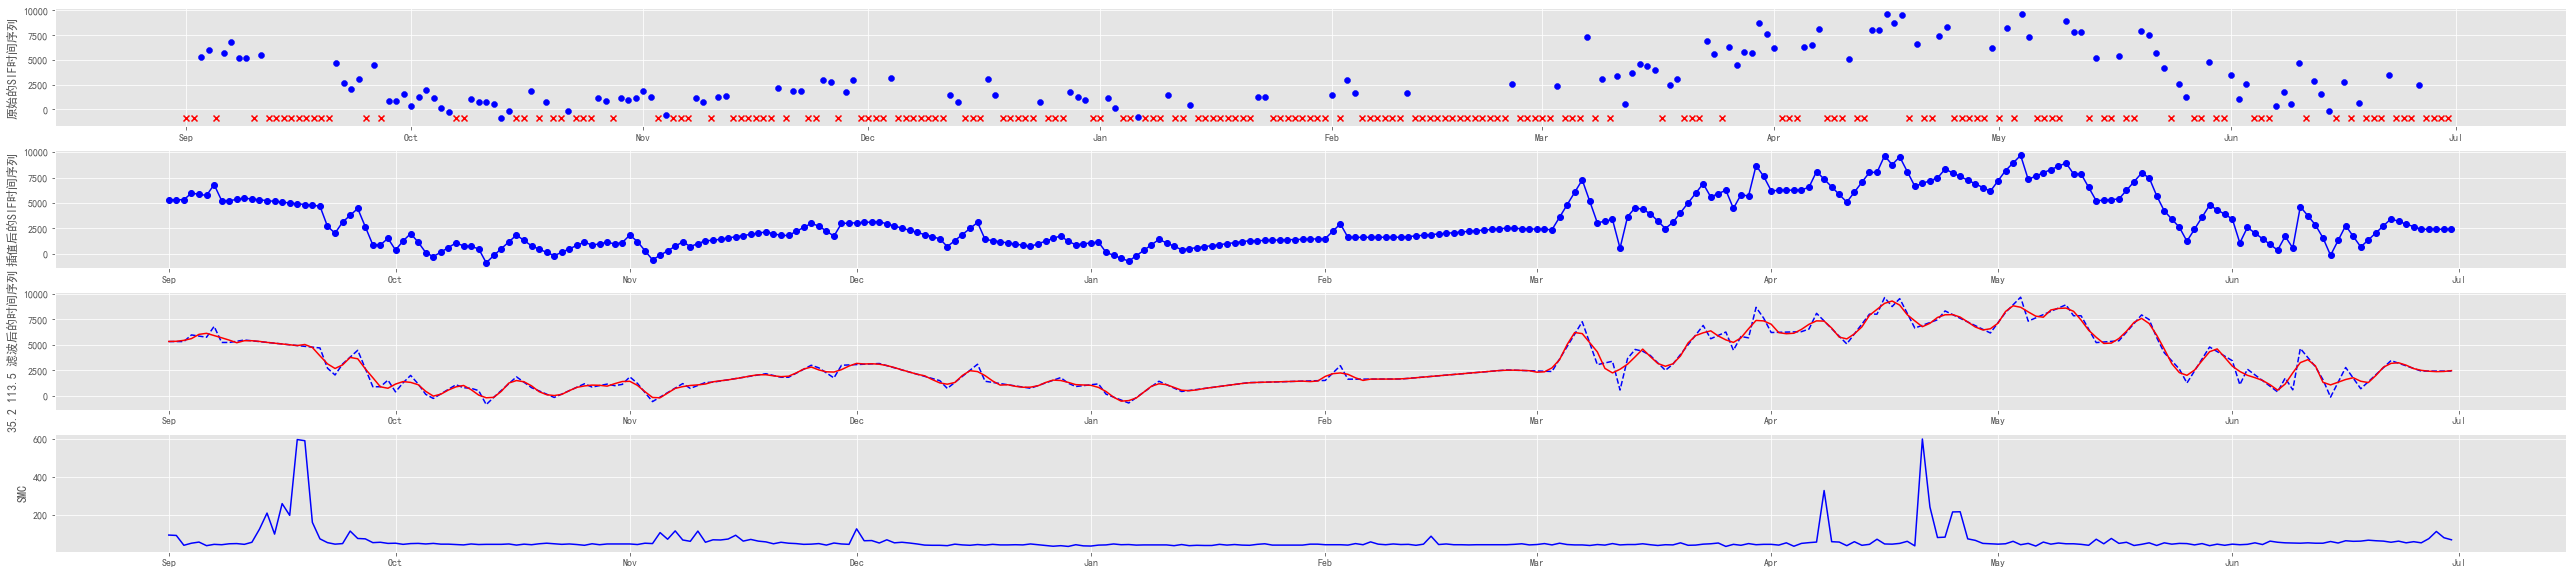

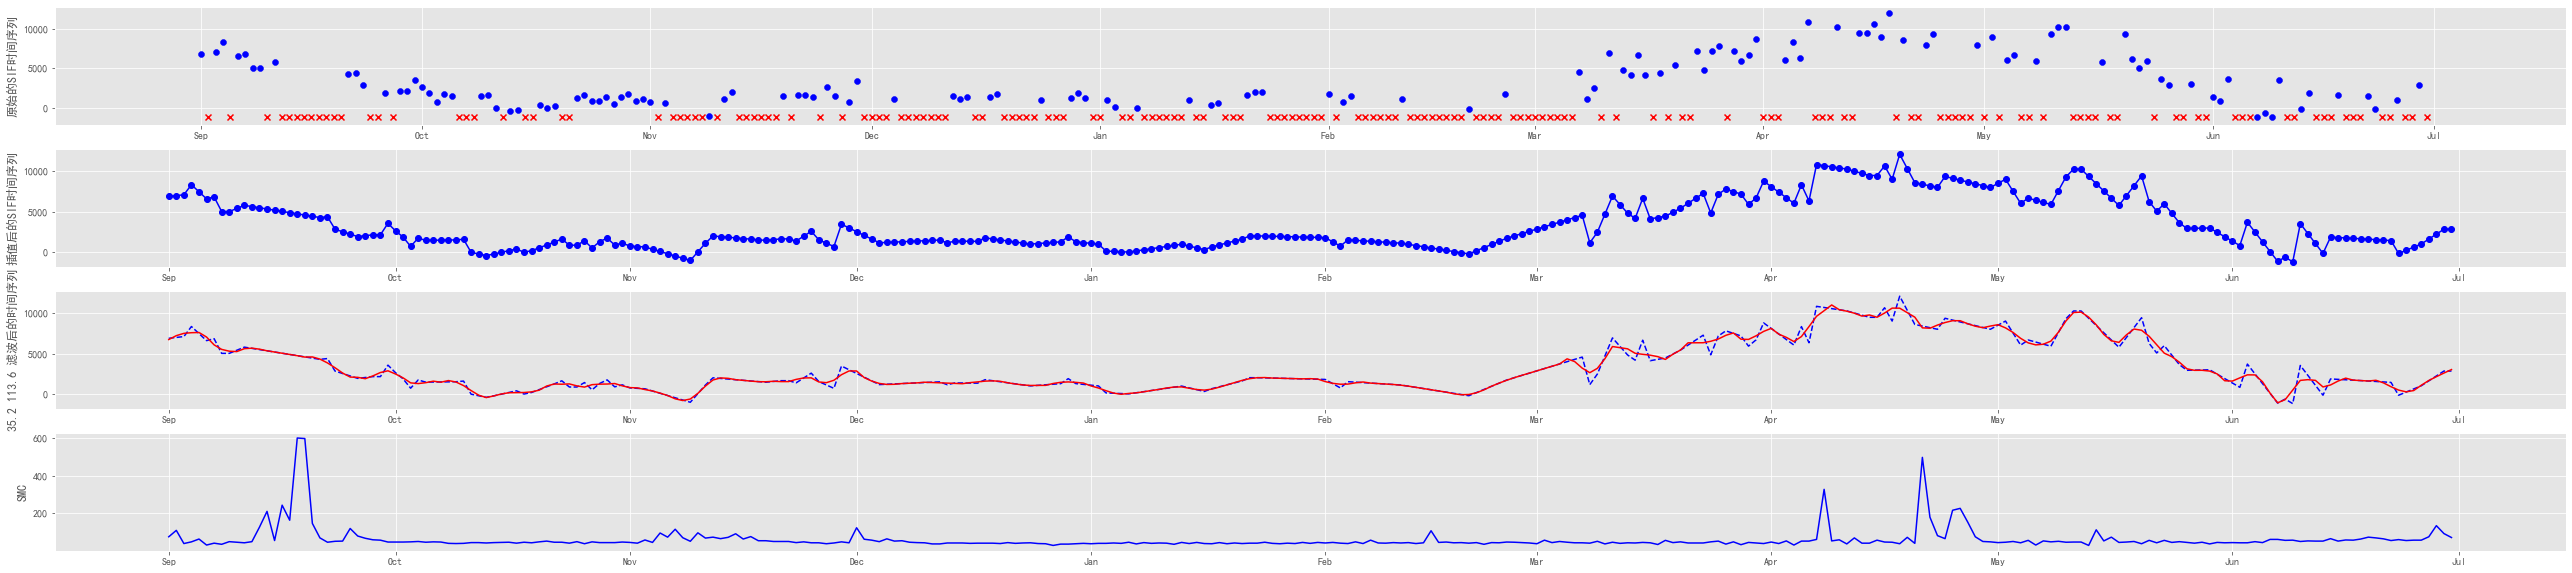

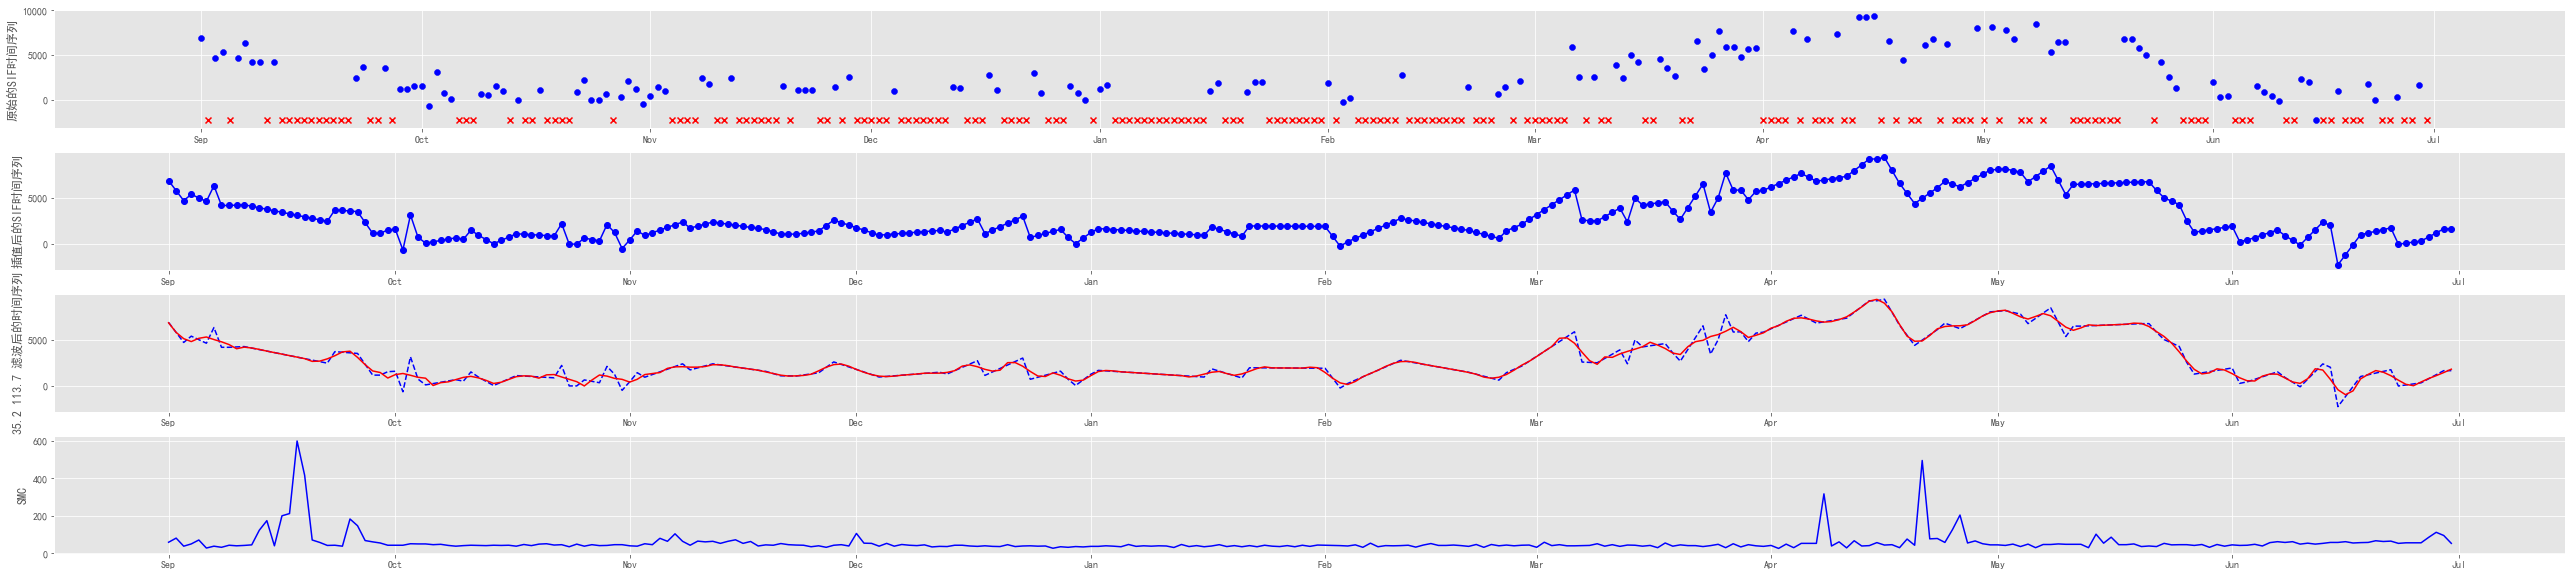

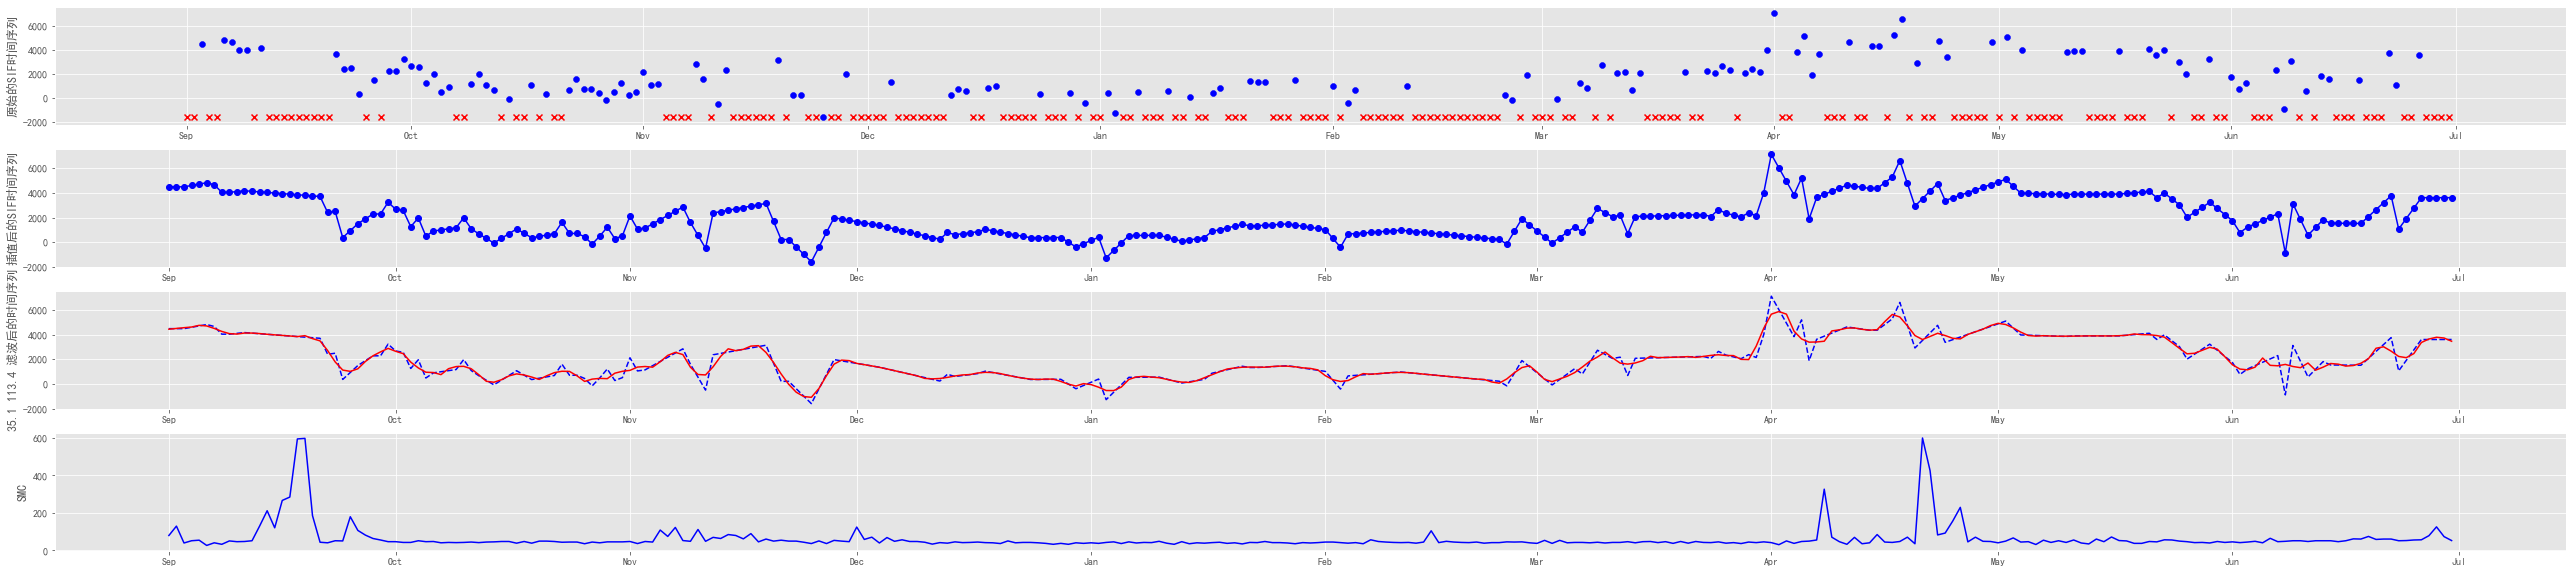

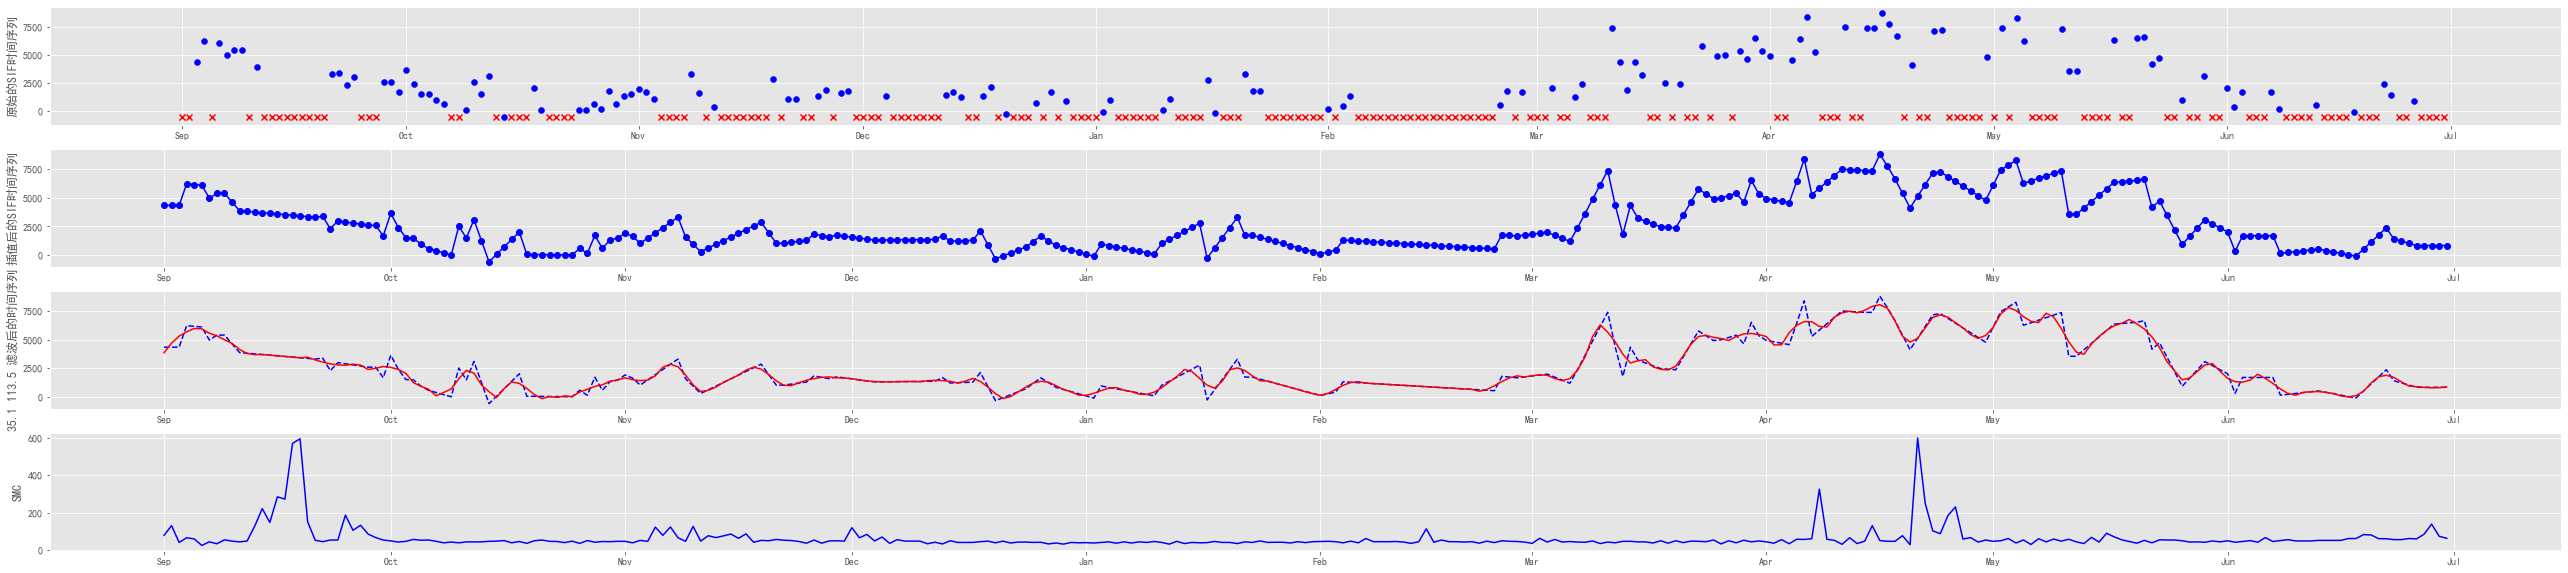

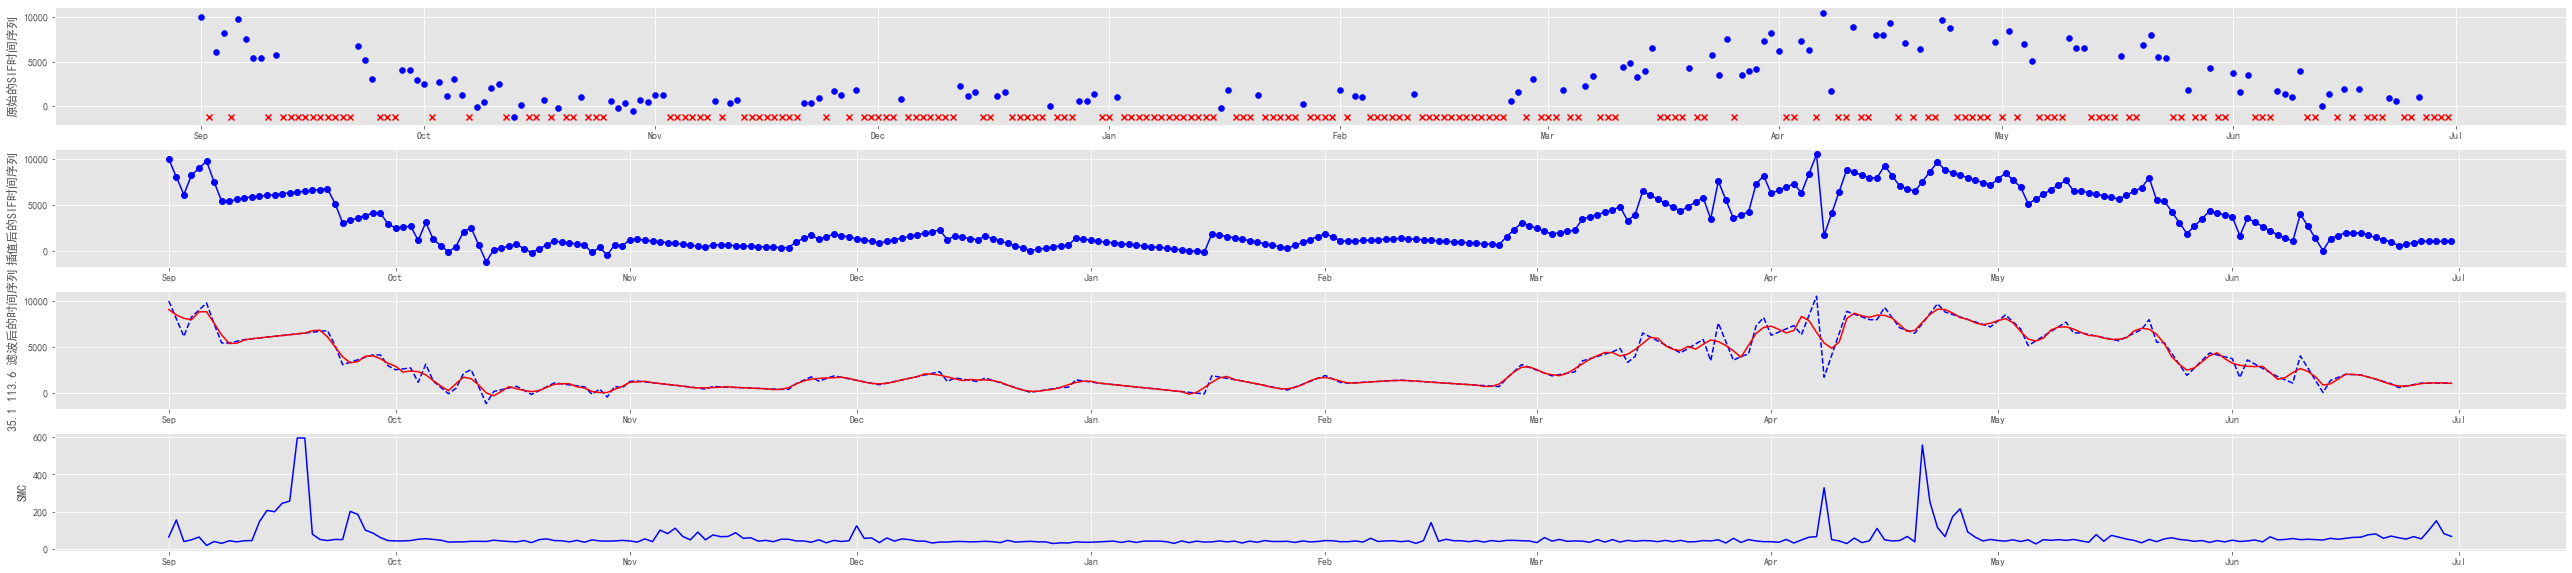

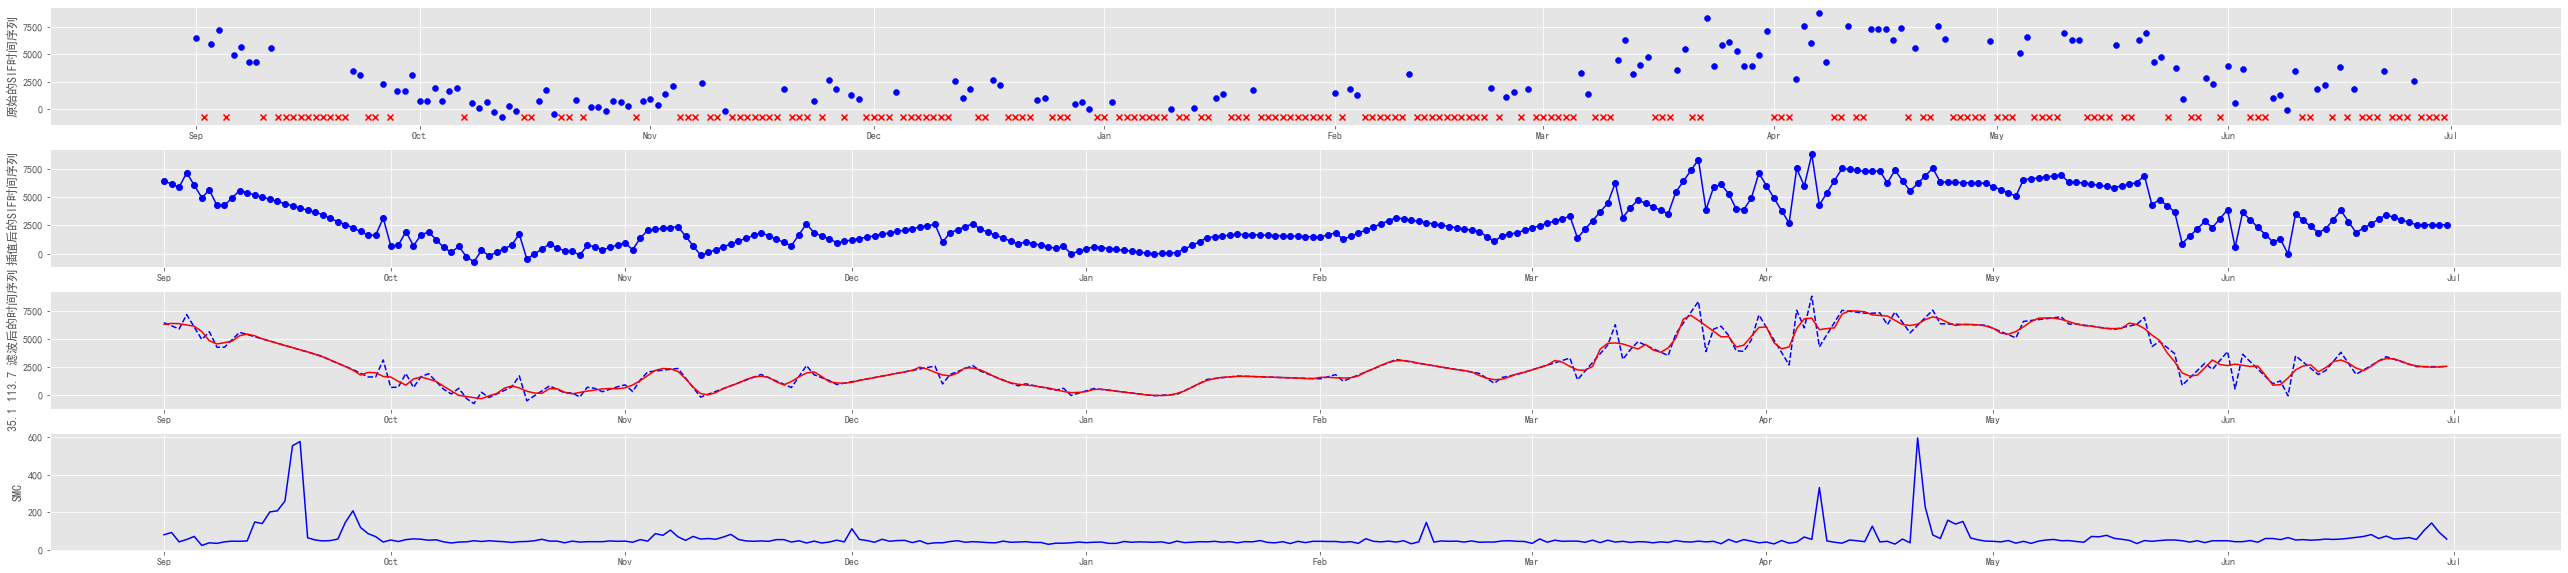

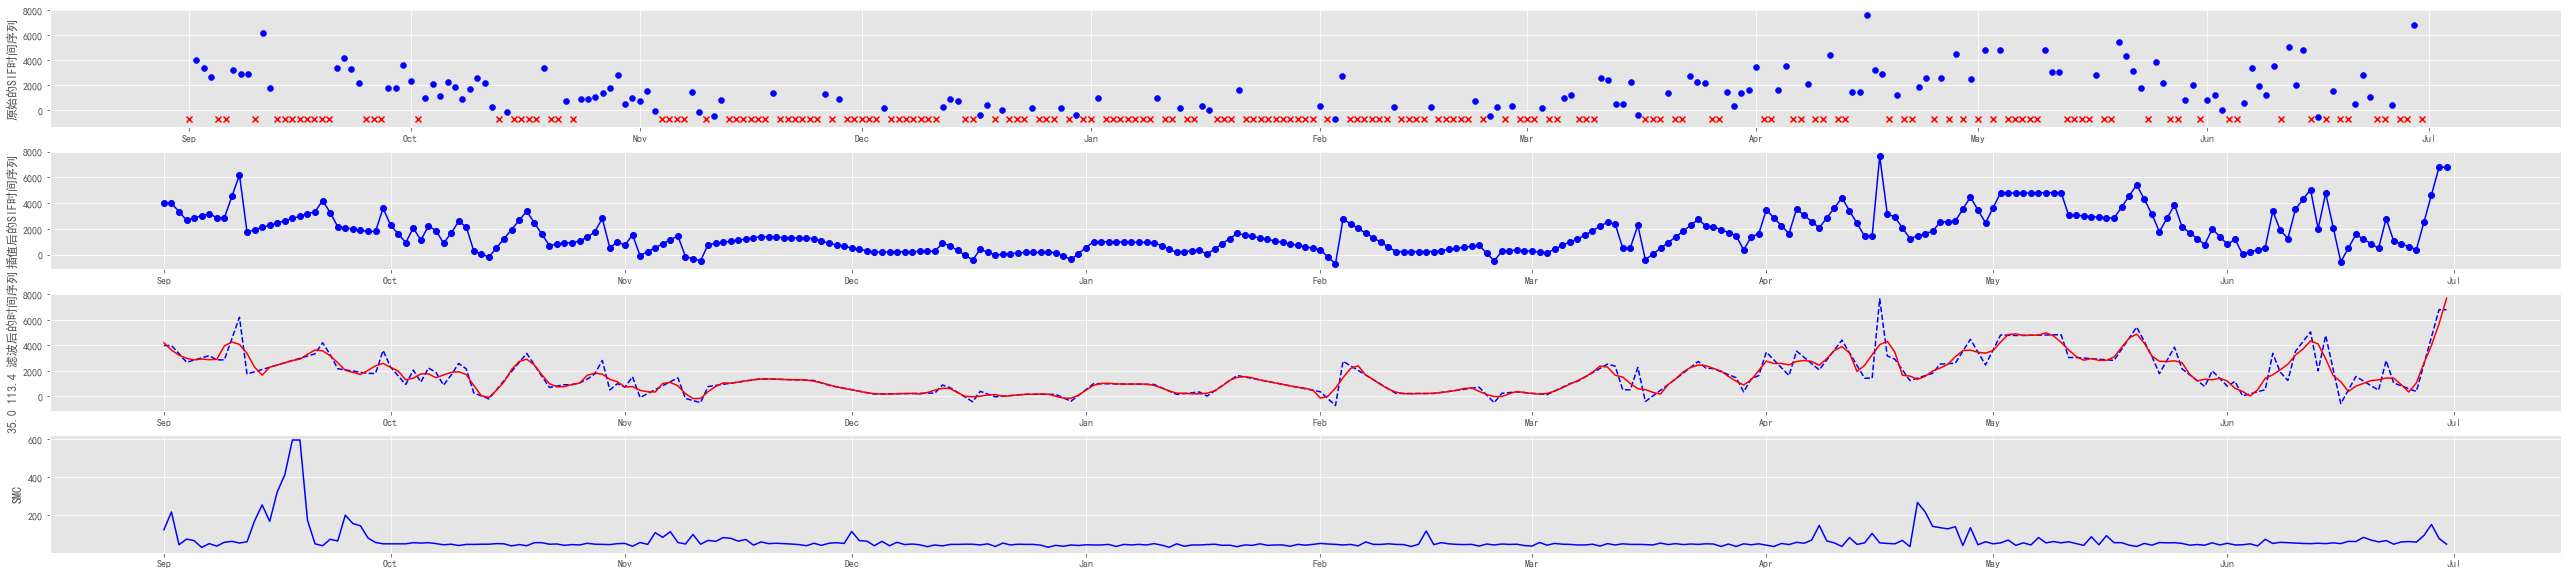

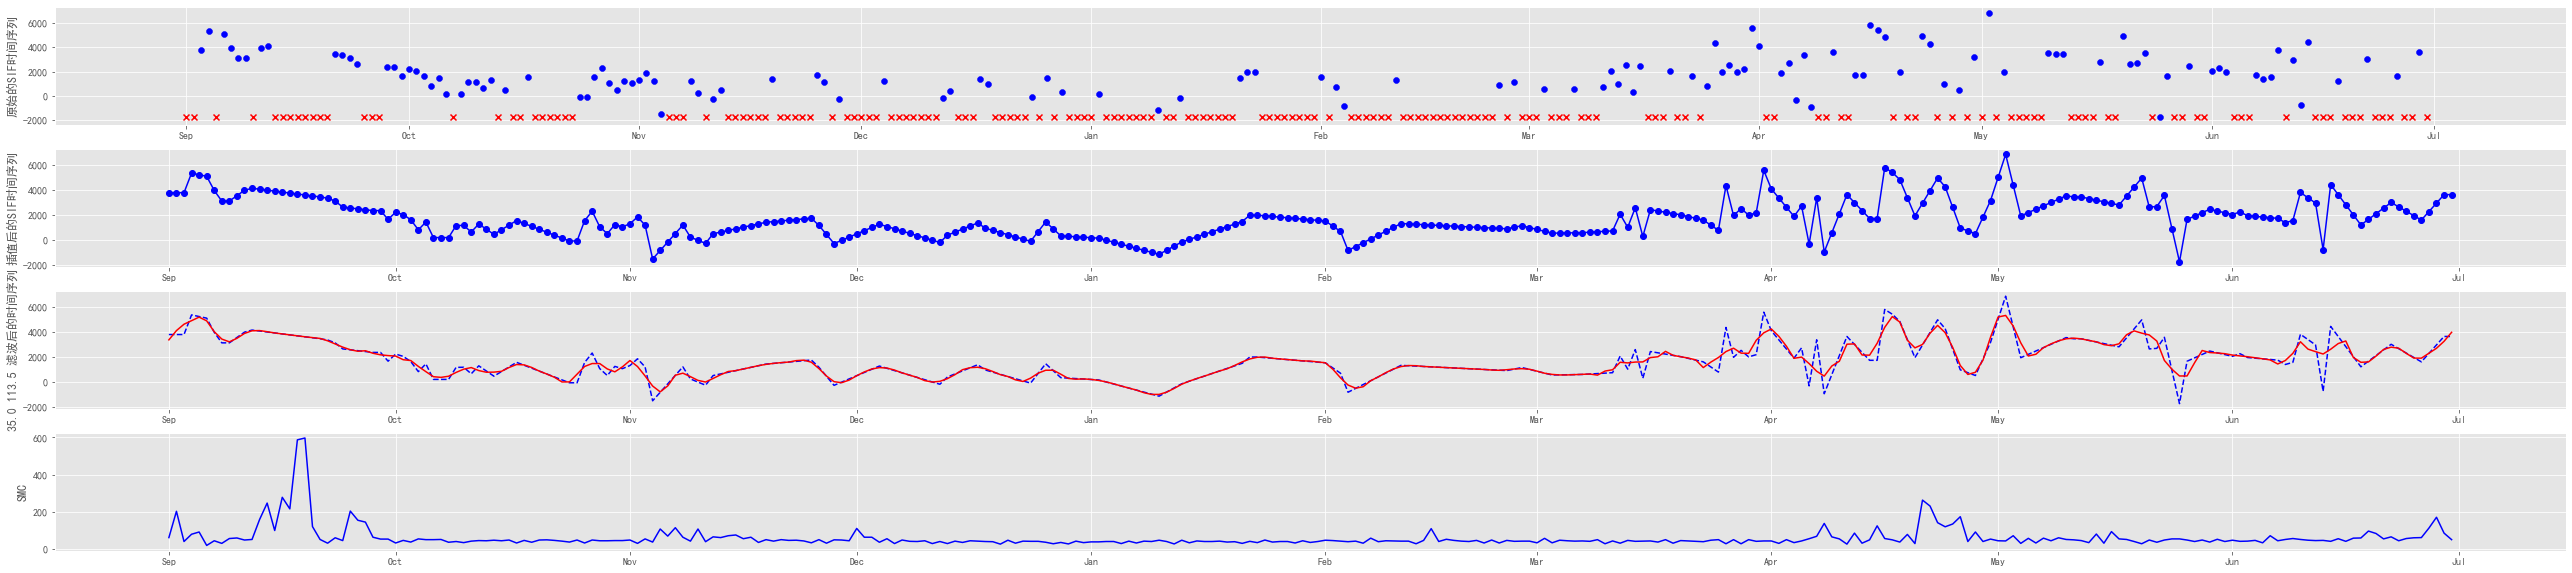

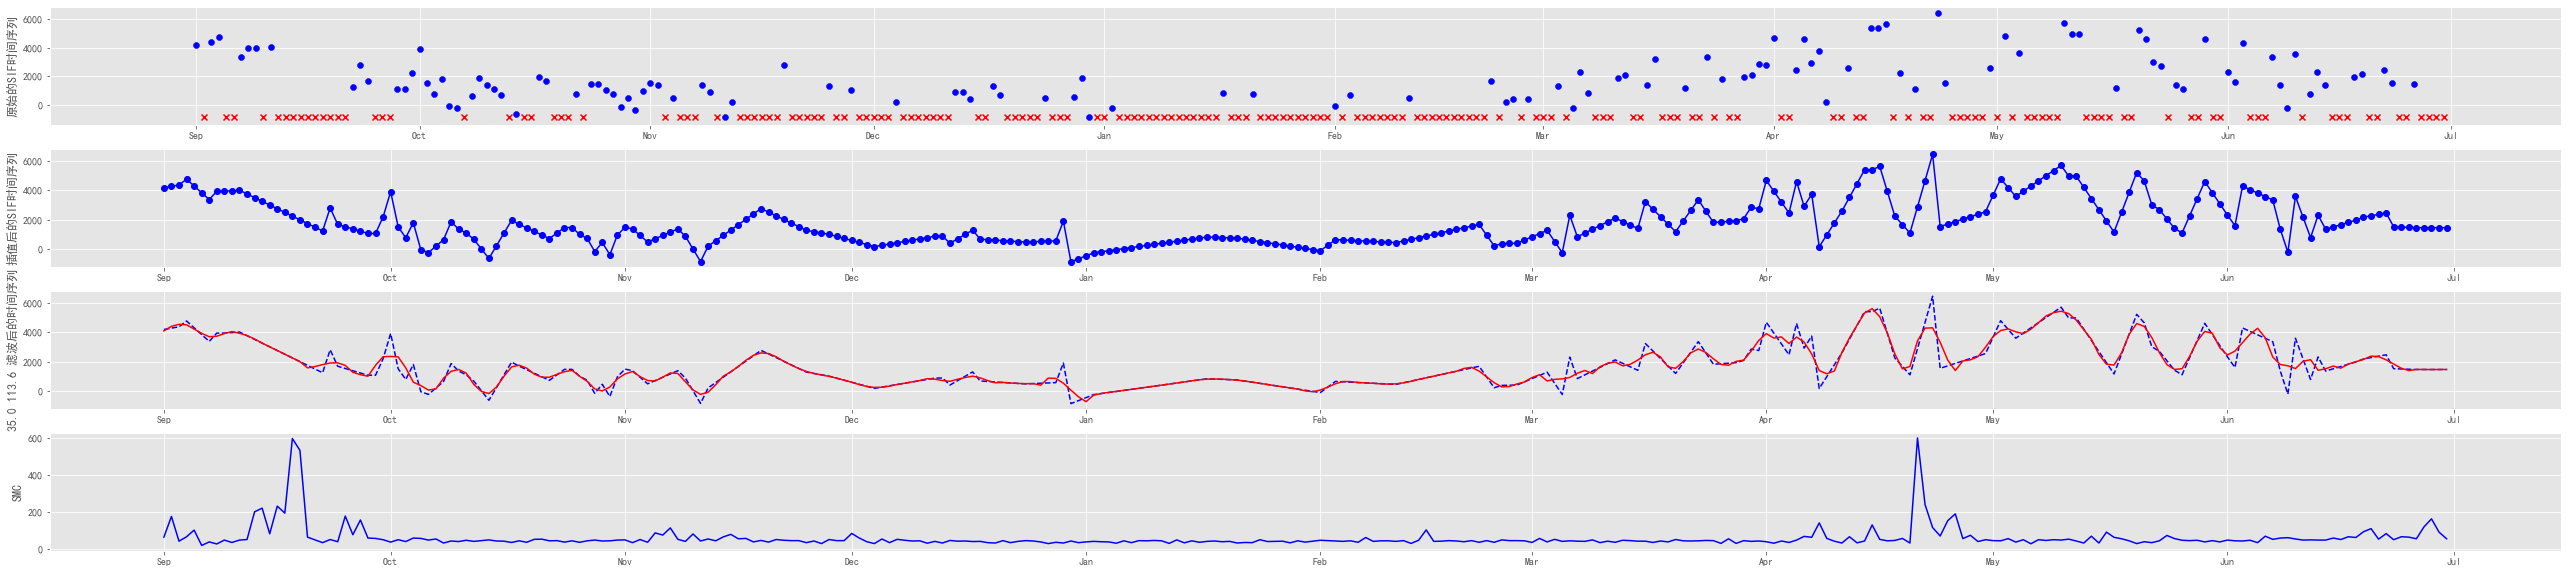

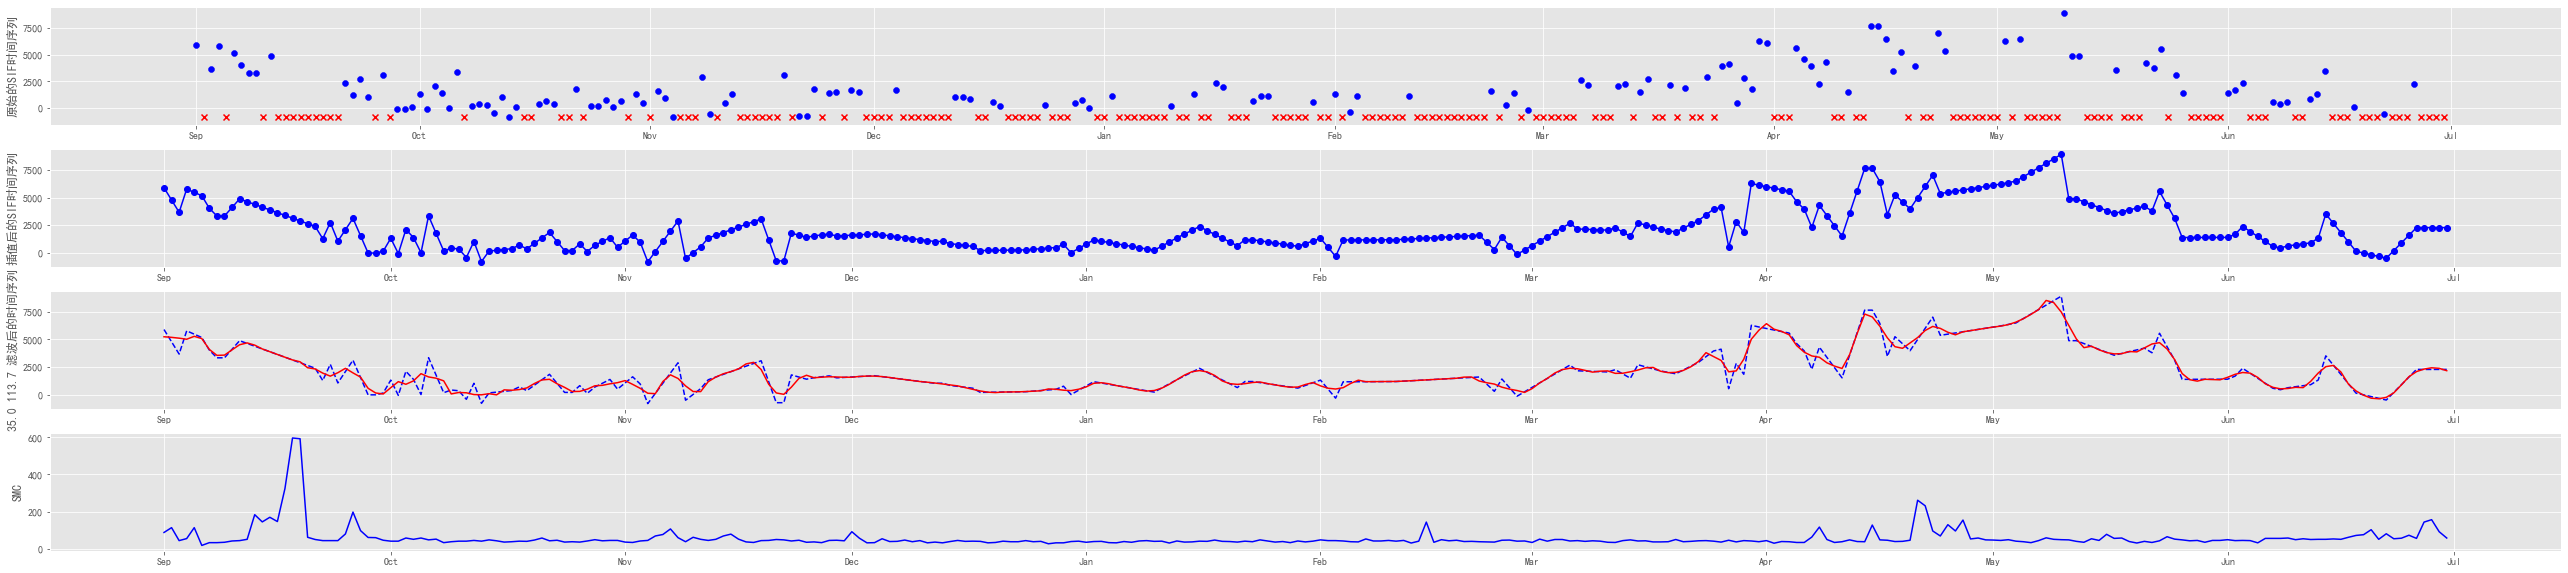

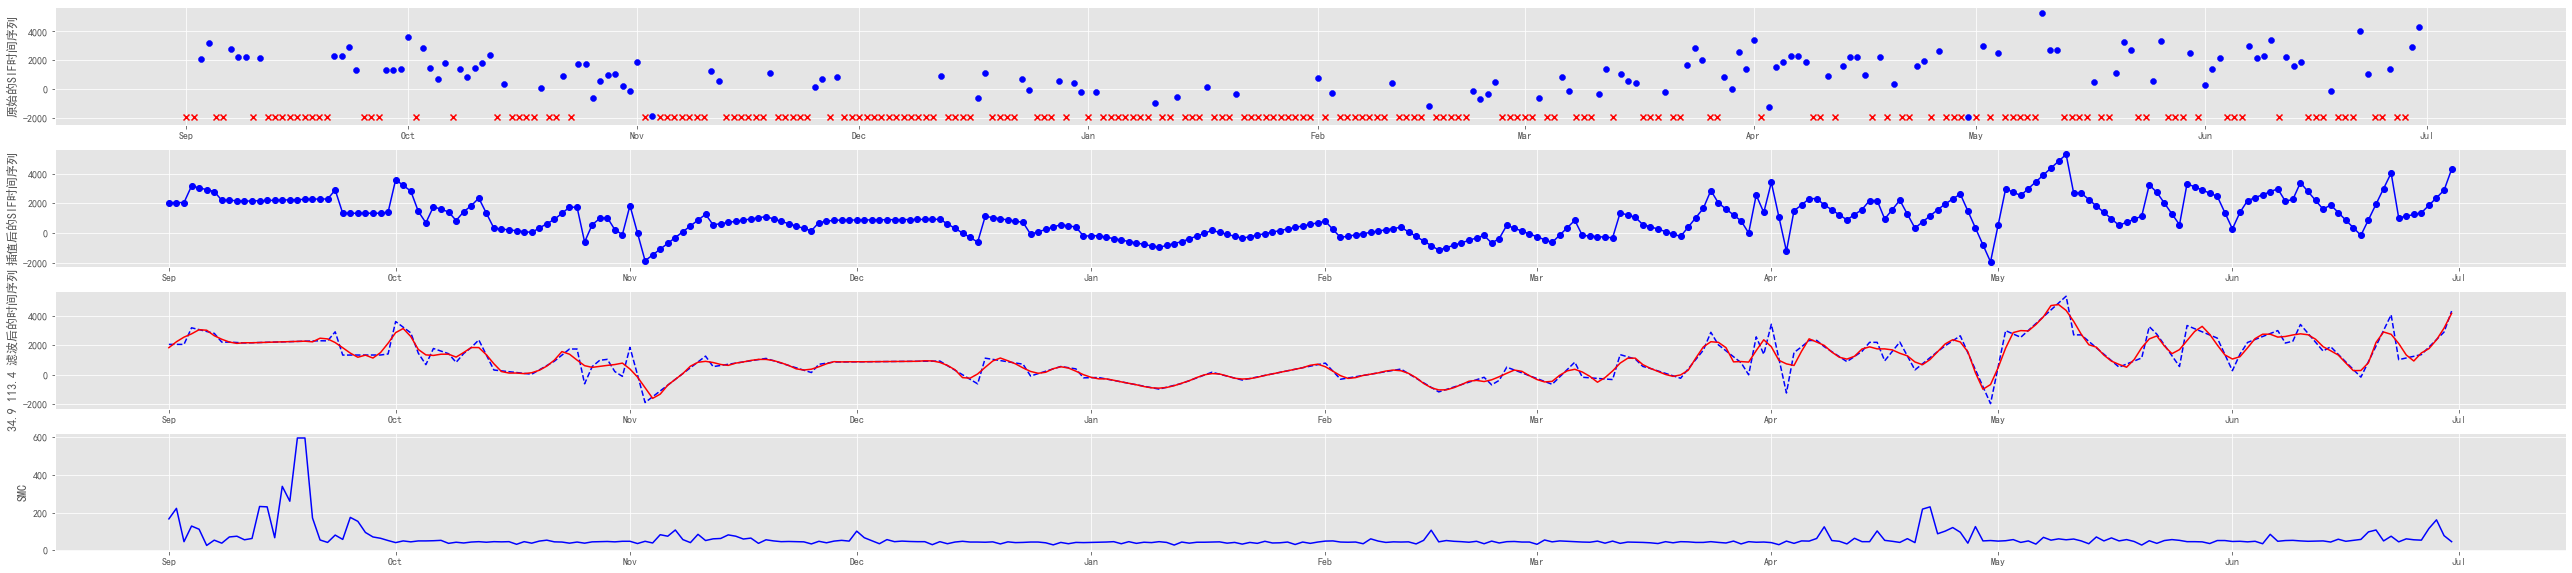

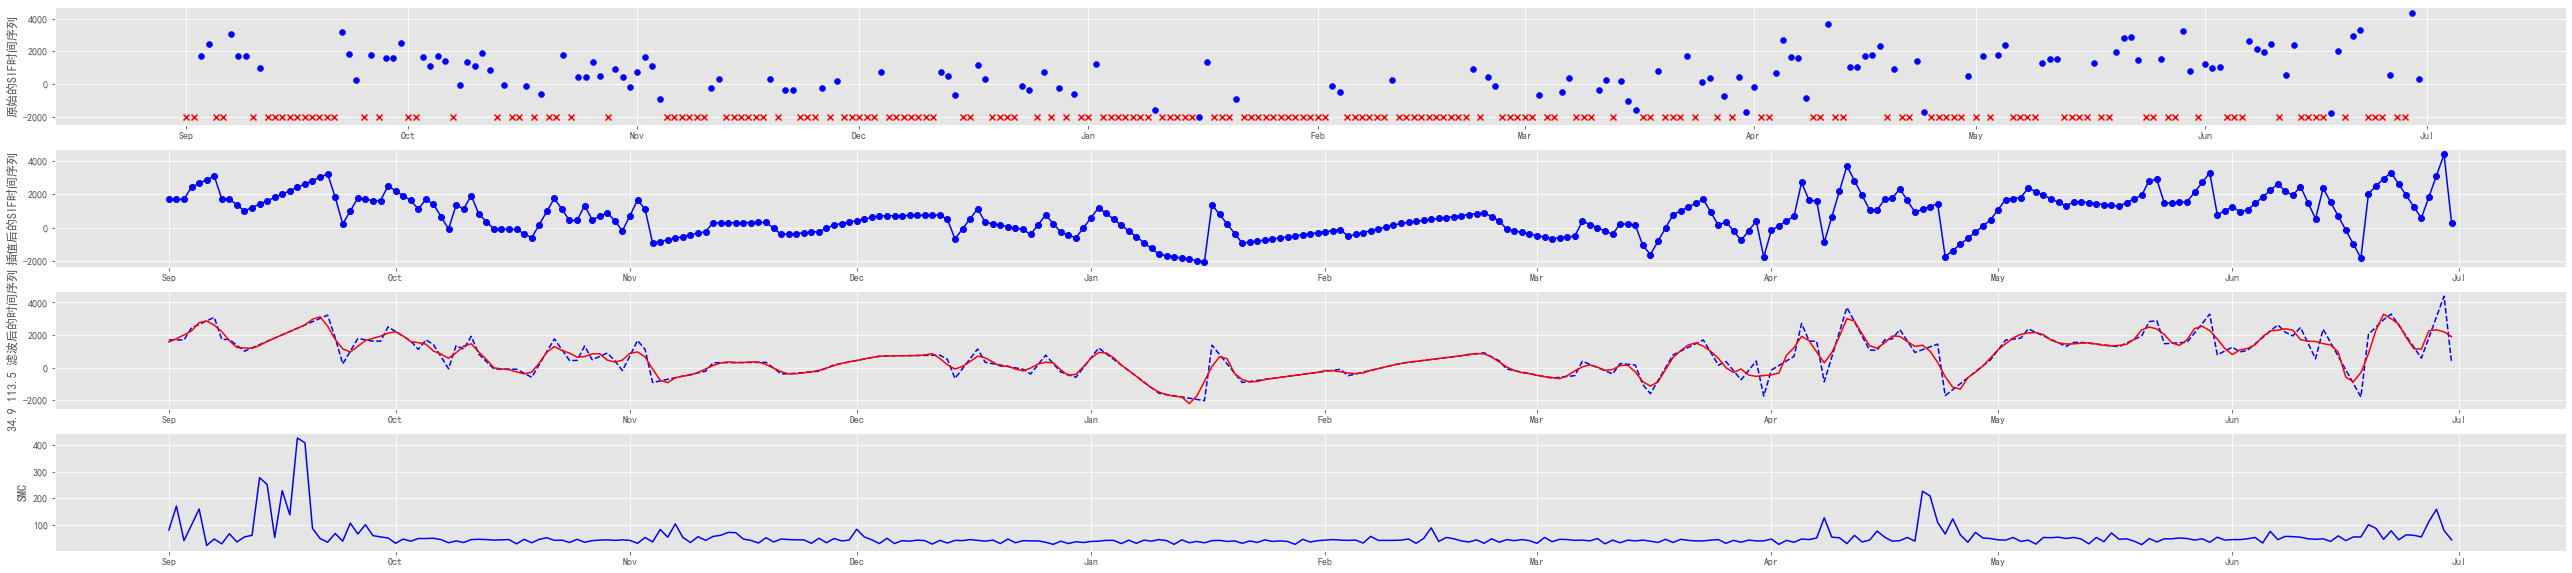

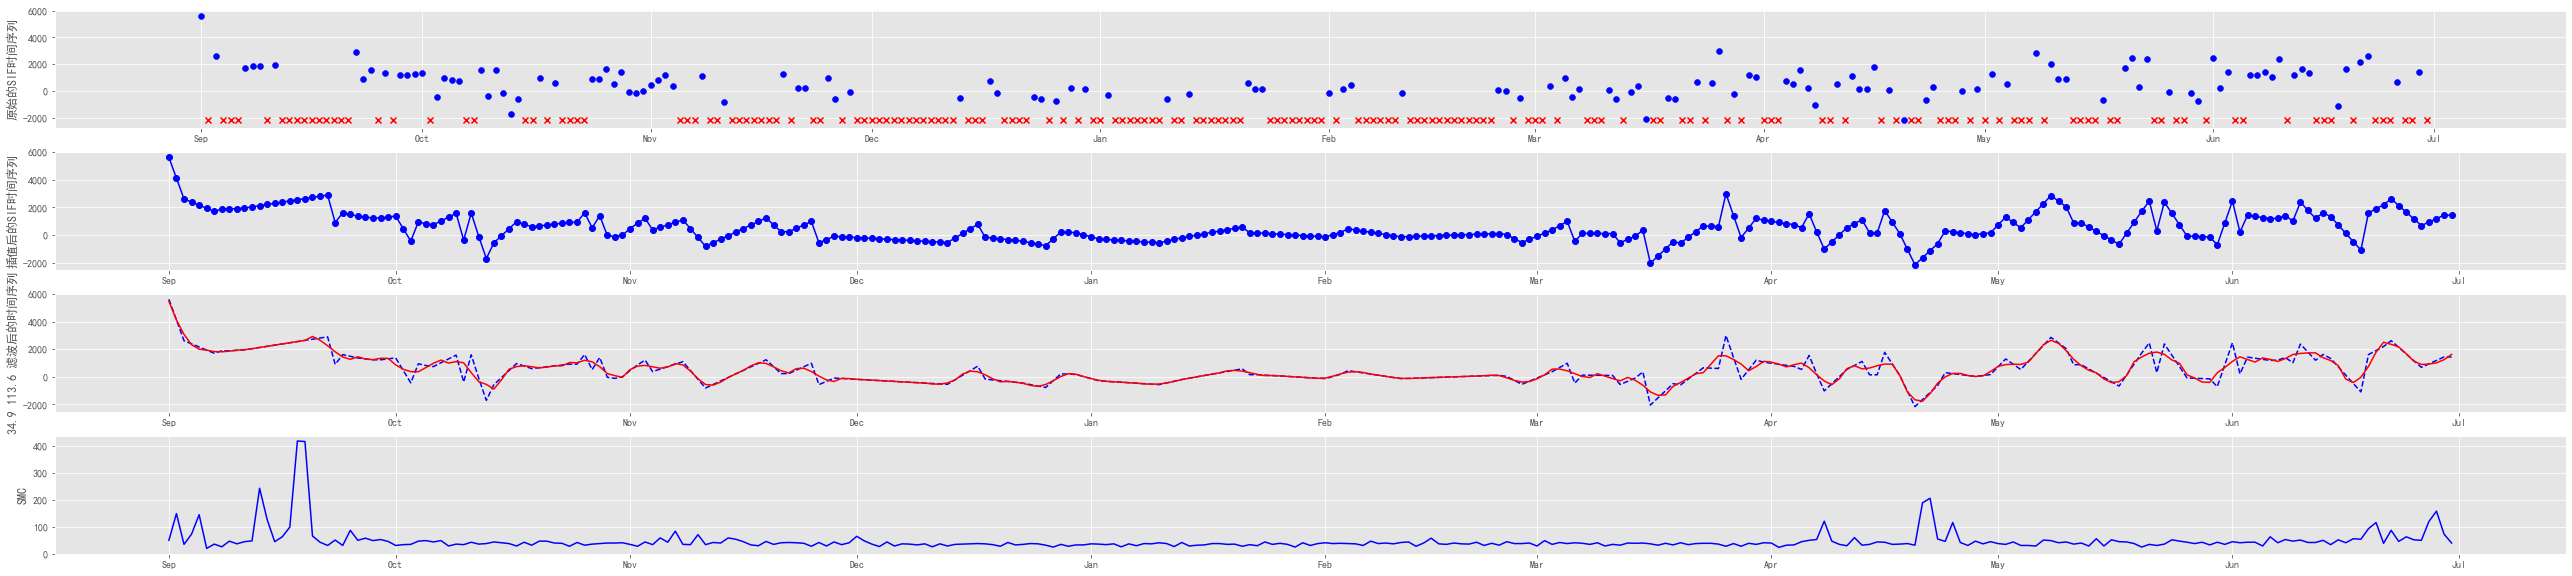

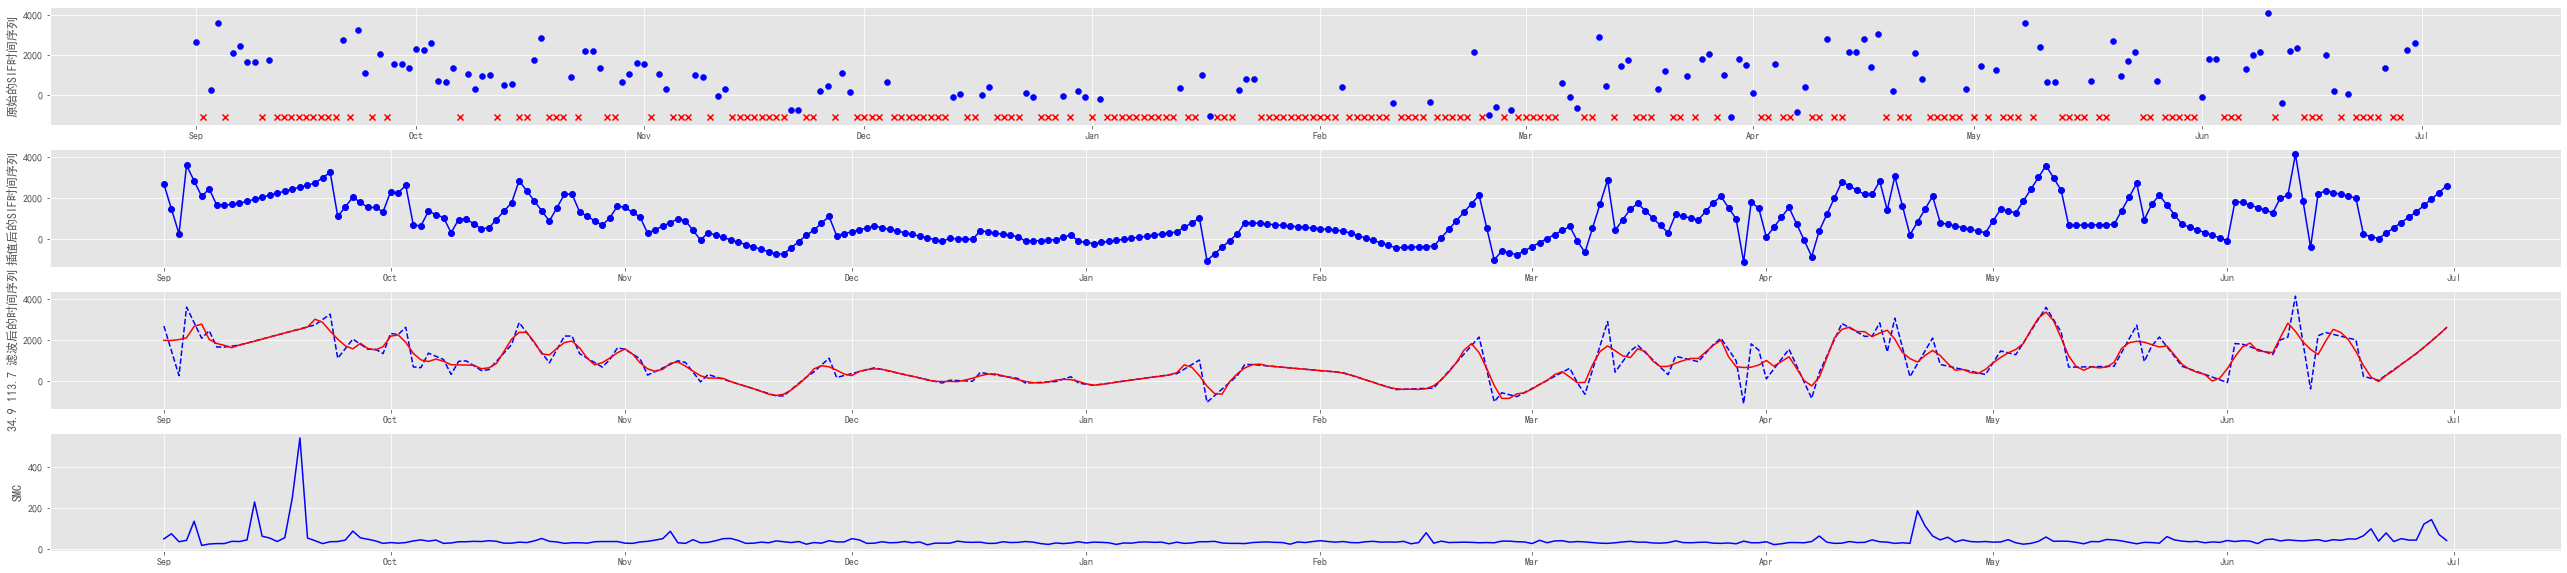

In [9]:
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
from osgeo import osr,ogr,gdal
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
from glob import glob 
import os 
import math 
import numpy as np
from scipy import interpolate
from scipy.signal import savgol_filter
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from datetime import datetime

dates = np.arange('2018-09-01', '2019-07-01', dtype='datetime64[1D]').astype(datetime)


def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)

    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data)-1 not in idx_x:
        idx_x.append(len(data)-1)
        idx_y.append(idx_y[-1])

    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data)):
        if math.isnan(data[i]):
            data[i] = lin(i)
    return data


tiff_path = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/dcSIF/MEAN/'#将0.1°分辨率的叶绿素荧光tiff文件读入到array数组中
filelist = glob(tiff_path+'*.tif')
filelen = len(filelist)
tif=gdal.Open(filelist[0])
width = tif.RasterXSize
height = tif.RasterYSize
array = np.zeros((filelen,height,width),dtype=np.float64)
i = 0
for file in filelist:
    #时间序列的SIF数组
    dataset = gdal.Open(file)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    data = dataset.ReadAsArray(0,0,width,height)
    array[i,:,:]=data
    i+=1


tiff_path2 = 'E:/sm/tif_clip_avg/'#将0.1°分辨率的土壤水分tiff文件读入到array数组中
filelist2 = glob(tiff_path2+'*.tif')
filelen2 = len(filelist2)
tif2=gdal.Open(filelist2[0])
width2 = tif2.RasterXSize
height2 = tif2.RasterYSize
array2 = np.zeros((filelen2,height2,width2),dtype=np.float64)
i = 0
for file in filelist2:
    #时间序列的SIF数组
    dataset = gdal.Open(file)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    data = dataset.ReadAsArray(0,0,width,height)
    array2[i,:,:]=data
    i+=1
lat_range = [35.2,34.8]#搜索范围上边界和下边界，纬度值先大后小
lon_range = [113.4, 113.8]#搜索范围左边界和右边界，纬度值先小后大
lat_up = int(round((43 - lat_range[0])*10))
lat_down = int(round((43 - lat_range[1])*10))
lon_left = int(round((lon_range[0] - 110.)*10))
lon_right =int(round((lon_range[1] - 110.)*10))
print(lat_up,lat_down,lon_left,lon_right)
XT = array[:,lat_up:lat_down,lon_left:lon_right]#第一个数是波段数；第二个数是高度，y，行数；第三个数是宽度，x，列数；[:,50:60,44:49]是50行到60行，38°到37°，44列到49列，114.4°到114.9°
#temp = array[1,50:60,44:50]
#plt.imshow(temp, cmap='viridis')
height = np.shape(XT)[1]#行数
width = np.shape(XT)[2]#列数
print(height,width)

for h in range(0,height):
    for w in range(0,width):
        smc = array2[:,lat_up+h,lon_left+w]
        x = array[:,lat_up+h,lon_left+w]#每个像素的时间序列
        x_min = np.min(x)
        length = len(dates)
        index = np.where(x == -99)
        dates_nan = dates[index]
        nan_length = len(dates_nan)# 无效时间区间长度
        x[np.where(x == -99)] = np.nan
        
        
        plt.figure(figsize = (45,10))
        ax=plt.subplot(411)
        ax.scatter(dates,x,c='b')
        ax_nan=np.zeros(nan_length)+x_min
        ax.scatter(dates_nan,ax_nan,c='r',marker = 'x')
        plt.ylabel('原始的SIF时间序列')
        monthsLoc = mpl.dates.MonthLocator()
        monthsFmt = mpl.dates.DateFormatter('%b') #%Y %b 为年月
        ax.xaxis.set_major_locator(monthsLoc)
        ax.xaxis.set_major_formatter(monthsFmt)
        
        
        ax2 = plt.subplot(412)
        xx = fillna_with_interpolation(x)#插值NAN值
        #ax2.plot(dates,xx,c='b',marker = '*',markerfacecolor='r',markeredgecolor='r')
        ax2.plot(dates,xx,c='b',marker = 'o')
        plt.ylabel('插值后的SIF时间序列')
        ax2.xaxis.set_major_locator(monthsLoc)
        ax2.xaxis.set_major_formatter(monthsFmt)
        

        ax3 = plt.subplot(413)
        yy = savgol_filter(xx,7,2)
        ax3.plot(dates,xx,'b',linestyle='--')
        ax3.plot(dates,yy,'r')
        lat = round((lat_range[0]-h*0.1),2)
        lon = round((lon_range[0]+w*0.1),2)
        plt.ylabel(str(lat)+' '+str(lon)+' 滤波后的时间序列')
        ax3.xaxis.set_major_locator(monthsLoc)
        ax3.xaxis.set_major_formatter(monthsFmt)
        
        ax4 = plt.subplot(414)
        #ax2.plot(dates,xx,c='b',marker = '*',markerfacecolor='r',markeredgecolor='r')
        ax4.plot(dates,smc,c='b')
        plt.ylabel('SMC')
        monthsLoc = mpl.dates.MonthLocator()
        monthsFmt = mpl.dates.DateFormatter('%b') #%Y %b 为年月
        ax4.xaxis.set_major_locator(monthsLoc)
        ax4.xaxis.set_major_formatter(monthsFmt)
        #break
    #break